Multigrid in FEM, modified from the original one.

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MeshHandler():
    """ Handle the square mesh, quad elements
    0: background square; 1: circular region
    
    Parameters:
        size: length of the square plate
        nnode_edge: number of nodes along edges of the plate
    """

    def __init__(self, size = 2, prop = [1,1], nnode_edge = 65, outfile = None):
        self.size = size
        self.nnode_edge = nnode_edge
        self.points, self.cells, self.mesh = None, None, None
        self.node_list = np.arange(nnode_edge*nnode_edge)
        self.generate_mesh()
        self.generate_node_index()
        if outfile is not None:
            self.save_mesh(outfile)

    def generate_mesh(self):
        x = np.linspace(self.size/2,-self.size/2,self.nnode_edge, dtype=np.float32)
        y = np.linspace(-self.size/2,self.size/2,self.nnode_edge, dtype=np.float32)
        ms_x, ms_y = np.meshgrid(x,y)
        x = np.ravel(ms_x).reshape(-1,1)
        y = np.ravel(ms_y).reshape(-1,1)
        z = np.zeros_like(x, dtype=np.float32)
        self.points = np.concatenate((x,y,z),axis=1)
        n_element = (self.nnode_edge-1)*(self.nnode_edge-1)
        nodes = np.linspace(0,self.points.shape[0],self.points.shape[0],endpoint=False,dtype=int).reshape(self.nnode_edge,self.nnode_edge)
        self.cells = np.zeros((n_element,4),dtype=int)
        self.cells[:,0] = np.ravel(nodes[:self.nnode_edge-1,:self.nnode_edge-1])
        self.cells[:,1] = np.ravel(nodes[:self.nnode_edge-1,1:])
        self.cells[:,2] = np.ravel(nodes[1:,1:])
        self.cells[:,3] = np.ravel(nodes[1:,:self.nnode_edge-1])
        self.mesh = meshio.Mesh(self.points, [("quad",self.cells)])

    def generate_node_index(self):
        '''Generate node index matrix that indicate boundary (True) or internal nodes (False)'''
        self.node_index = []
        for pt in self.points:
            if(np.isclose(pt[0],-1) or np.isclose(pt[0],1) or np.isclose(pt[1],-1)  or np.isclose(pt[1],1)):
                self.node_index.append(True)
            else:
                self.node_index.append(False)
        self.node_essential = self.node_list[self.node_index]
        self.node_internal = self.node_list[np.invert(self.node_index)]
    
    def shapefunc(self, p):
        # shape function
        N = 0.25*np.array([[(1-p[0])*(1-p[1])],
                           [(1+p[0])*(1-p[1])],
                           [(1+p[0])*(1+p[1])],
                           [(1-p[0])*(1+p[1])]])

        dNdp = 0.25*np.array([[-(1-p[1]), -(1-p[0])],
                              [(1-p[1]), -(1+p[0])],
                              [(1+p[1]), (1+p[0])],
                              [-(1+p[1]), (1-p[0])]])
        return N, dNdp

    def save_mesh(self,outfile = 'plate_mesh.vtk'):
        self.mesh.write(outfile)

In [3]:
class GridFEM():
    '''
    Note: the n should be the number of intervals, e.g., 
    there are (n-1)*(n-1) internal grid points 
    '''
    def __init__(self, n, size = 2):
        self.size = size
        self.n = n 
        self.omega = 2/3
        self.property = [1, 1] # homogeneous problem
        self.qpts = np.array([[-1, 1, 1, -1], [-1, -1, 1, 1]])/np.sqrt(3) #[2x4]
        self.v = np.zeros((n-1)*(n-1))
        self.f = np.zeros((n-1)*(n-1))
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.A, self.A_EF = self.CreateA()

    def IsCoarsest(self):
        return self.n == 2
        
    def CreateA(self):
        '''
        Stiffness matrix 
        ''' 
        A = np.zeros(((self.n+1)*(self.n+1),(self.n+1)*(self.n+1)))
        for c in self.grid.cells:
            xe = self.grid.points[c,:].T[:2,:] #[2x4]
            D = np.eye(2)
            Ke = np.zeros((4,4))
            for q in self.qpts.T:
                [_,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                dNdx = np.dot(dNdp, np.linalg.inv(J)) #[4x2]
                B = np.zeros((2,4))
                B[0,:] = dNdx[:,0]
                B[1,:] = dNdx[:,1]
                Ke += np.linalg.det(J)*np.dot(B.T,np.dot(D,B))
            A[np.ix_(c,c)] += Ke
            
        return A[np.ix_(self.grid.node_internal,self.grid.node_internal)], A[np.ix_(self.grid.node_essential,self.grid.node_internal)]

    def UpdateRHS(self, f):
        '''
        Return the internal part of rhs sourcing term with modification from finite element term
        '''
        ff = np.zeros((self.n+1)*(self.n+1))
        f_temp = np.zeros((self.n+1)*(self.n+1))
        f_temp[self.grid.node_internal] = f
        for c in self.grid.cells:
            xe = self.grid.points[c,:].T[:2,:] #[2x4]
            fe = np.zeros(4)
            for q in self.qpts.T:
                [N,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                temp = np.linalg.det(J)*np.dot(N,np.dot(N.T,f_temp[c])) #[4x1]
                fe += temp
            ff[c] += fe
        return ff[self.grid.node_internal]

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iterations for current level of grid
        '''
        Dinv = np.diag(1.0/np.diag(self.A))
        v = self.v
        for i in range(num_sweeps_down):
            vprev = v
            residual = self.f - np.dot(self.A,vprev)
            v = self.omega*np.dot(Dinv,residual) + vprev
        return v

In [4]:
class Multigrid():
    '''
    Define the multigrid problem for 2D
    '''
    def __init__(self, n = 64):

        # Problem parameters
        C = 5.0
        k = 1
        l = 2

        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.solution = []

        self.size_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        internal_pts = self.grids[0].grid.points[self.grids[0].grid.node_internal,:] # internal node coordinates of finest grid
        sourcing_term = C*np.sin(k*np.pi*internal_pts[:,0])*np.sin(l*np.pi*internal_pts[:,1])
        self.u_exact = C/(np.power(np.pi*k,2)+np.power(np.pi*l,2))*np.sin(k*np.pi*internal_pts[:,0])*np.sin(l*np.pi*internal_pts[:,1])  # exact solution

        ff = self.grids[0].UpdateRHS(sourcing_term)
        
        # we can do following because essential bc is zero
        self.grids[0].f = ff # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = GridFEM(self.size_arr[i])
        return grids

    def SizeArray(self):
        size_arr = []
        for i in range(self.L):
            size_arr.append(int(self.n/(2.**i)))
        size_arr = np.array(size_arr)
        return size_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        size = int(np.sqrt(f.shape[0]))
        size_res = int((size-1.)/2.)  # size of the restricted level
        f_2d = f.reshape((size,size))
        f_2d_res = np.zeros((size_res,size_res))

        # down sampling in 2D
        for i in range(size_res):
            for j in range(size_res):
                f_2d_res[i,j] = 1./16.*(4*f_2d[2*i+1,2*j+1]+2*(f_2d[2*i+1,2*j]+f_2d[2*i+1,2*j+2]+f_2d[2*i,2*j+1]+f_2d[2*i+2,2*j+1])+
                                         f_2d[2*i,2*j]+f_2d[2*i,2*j+2]+f_2d[2*i+2,2*j]+f_2d[2*i+2,2*j+2])

        return f_2d_res.reshape(-1)

    def InterpolateOp(self):
        interpolate_op = [None]
        for i in range(1,self.L):
            size_current = self.size_arr[i]
            size_prev = self.size_arr[i-1]
            int_temp = np.zeros((size_prev+1,size_current+1))
            stencil = 1./2.*np.array([1,2,1])
            for j in range(size_current-1):
                int_temp[2*j+1:2*j+4,j+1] = stencil
            interpolate_op.append(int_temp[1:-1,1:-1])
        return interpolate_op

    def Interpolate(self, v):
        '''
        Perform linear interpolation to up sample to previous level
        '''
        size = int(np.sqrt(v.shape[0]))
        size_int = int(size*2+1)  # size of the interpolated level
        v_2d = v.reshape((size,size))
        op = self.InterpolateOp()
        level = np.where(self.size_arr == size+1)[0][0]

        v_temp = np.zeros((size,size_int))
        # up sampling row by row
        for i in range(size):
            v_temp[i,:] = np.dot(op[level],v_2d[i,:])

        # up sampling col by col
        v_2d_int = np.zeros((size_int,size_int))
        for j in range(size_int):
            v_2d_int[:,j] = np.dot(op[level],v_temp[:,j])

        return v_2d_int.reshape(-1)

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return np.linalg.norm(v-self.u_exact.reshape(-1), ord=np.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].v = self.grids[l].Relax(n_sample)
        if(not self.grids[l].IsCoarsest()):
            sourcing_term = self.Restrict(self.grids[l].f - np.dot(self.grids[l].A, self.grids[l].v))
            self.grids[l+1].f = 4*sourcing_term 
            self.grids[l+1].v *= 0.
            self.grids[l+1].v = self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(n_sample) 
        return self.grids[l].v

    def plot(self):
        '''Plot the solution vector v in 2D'''
        self.solution = self.grids[0].v
        uu = self.solution.reshape(self.xx.shape)
        fig = plt.figure()
        plt.contourf(self.x,self.y,uu)
        plt.axis('scaled')
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.colorbar()


In [5]:
n = 64
prob = Multigrid(n)

In [6]:
# Weighted Jacobi iteration
EPS = 1e-6
n_jacobi = 0
u_jacobi = np.zeros((n-1)*(n-1))
e_jacobi = 1
e_relative_jacobi = [e_jacobi]
while (e_jacobi>EPS):
    u_prev = u_jacobi
    prob.grids[0].v = u_jacobi
    u_jacobi = prob.grids[0].Relax(1)
    e_jacobi = np.sqrt(np.sum((u_jacobi - u_prev) ** 2)) / np.sqrt(np.sum((u_jacobi) ** 2))
    e_relative_jacobi.append(e_jacobi)
    print(e_jacobi)
    n_jacobi += 1

print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

1.0
0.49698590051046143
0.3293226579694888
0.24549712922284664
0.19520668549804016
0.16168378375290732
0.1377423340111427
0.11978929119618767
0.10582851907586865
0.09466233584025946
0.08552858027344395
0.07791914483940307
0.07148226272826763
0.06596667188275336
0.061188113414027065
0.05700839311162725
0.053321833008711225
0.050046239092223936
0.04711672131512229
0.044481367604935894
0.042098153869885316
0.039932696730607495
0.03795659249578214
0.03614617139385428
0.034481550789146345
0.03294590688656237
0.031524908279693814
0.03020627088147672
0.02897940493816335
0.027835132640501963
0.026765460390819337
0.025763393770027503
0.02482278614699489
0.02393821400391273
0.02310487363445775
0.022318495058929477
0.021575269899096874
0.020871790641228724
0.02020499924327483
0.019572143450971663
0.018970739506714535
0.018398540185735293
0.01785350729234964
0.0173337879067176
0.01683769379870393
0.01636368352688852
0.015910346822810756
0.015476390927184568
0.015060628599231211
0.01466196756489327

In [7]:
# Multigrid solving procedure
EPS = 1e-6
n_recV_cycle = 0
u_rec_cycle = np.zeros((n-1)*(n-1))
f_cycle = prob.grids[0].f
e_recV_cycle = 1
e_relative_recV = [e_recV_cycle]
while (e_recV_cycle>EPS):
    u_prev = u_rec_cycle
    u_rec_cycle = prob.rec_V_cycle(0,u_rec_cycle,f_cycle)
    e_recV_cycle = np.sqrt(np.sum((u_rec_cycle - u_prev) ** 2)) / np.sqrt(np.sum((u_rec_cycle) ** 2))
    e_relative_recV.append(e_recV_cycle)
    print(e_recV_cycle)
    n_recV_cycle += 1

print("Solution converges after ", n_recV_cycle, "V-cycle iterations")

1.0
0.17577383859667897
0.036351169894436465
0.00777298727793025
0.0016781936066585868
0.00036395781161741286
7.9199105978654e-05
1.7288964616211395e-05
3.7864684623274755e-06
8.321422695219624e-07
Solution converges after  10 V-cycle iterations


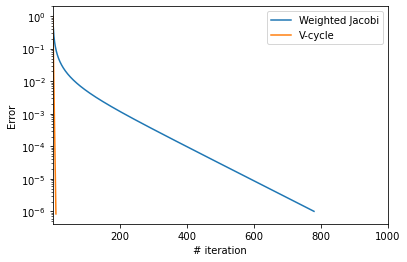

In [8]:
# Plot the relative error
plt.plot(e_relative_jacobi, label='Weighted Jacobi')
plt.plot(e_relative_recV, label='V-cycle')
#plt.xscale('log')
plt.yscale('log')
plt.xlim([1,1000])
plt.xlabel('# iteration')
plt.ylabel('Error')
plt.legend()